# HW Guide: Wage Growth During the Recession

This note is designed to help you understand the full scope of the task. The homework will have you fill in the code to implement some of the functions used here. This notebook will put together all of those functions so as to visualize the final result. If you want, you can first follow the steps of this notebook to help you write the code. You can then refactor the code by moving it into separate files and functions that are covered by the unit tests. The point of this document is to help guide you on the homework. 

Before you start this assignment, you'll have to install the `weightedstats` package. You can do this by running `pip install weightedstats` in a terminal. For more information, see here: https://pypi.org/project/weightedstats/ . We will use this package to compute a weighted median. The package is included in the `requirements.txt` for the HW repo, so you can just use that if you'd like. 

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import weightedstats
import seaborn as sns
sns.set()

import config
from pathlib import Path
import load_fred

DATA_DIR = Path(config.DATA_DIR)

In [2]:
import load_cps
import wage_growth_analytics

In [3]:
# Change default pandas display options
pd.options.display.max_columns = 25
pd.options.display.max_rows = 500
pd.options.display.max_colwidth = 100
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Change default figure size
plt.rcParams['figure.figsize'] = 6, 5

## 1. Introduction

Wages at the aggregate level have been found to rise during the recent recession (or at least not decline). This is surprising given that aggregate labor conditions were so weak. Many economists have viewed this as a puzzle. The goal in this question is to assess whether this is a puzzle, given that the composition of workers are changing over time. We begin by establishing the facts from which this puzzle arises. 

The great recession is generally defined as having lasted from December 2007 to June 2009. For example, see the corresponding article on Wikipedia: https://en.wikipedia.org/wiki/Great_Recession_in_the_United_States

> The Great Recession in the United States was a severe financial crisis combined with a deep recession. While the recession officially lasted from December 2007 to June 2009, it took several years for the economy to recover to pre-crisis levels of employment and output.


Consider the following graph. This graph plots the median weekly real earnings for wage and salary workers ages 16 years and older. The shaded areas in the plots denote officially defined periods of recession, as defined by NBER. Notice that wages during the period of the great recession appear to be increasing. In this document we will be investigating this fact.

![Median Real Earnings](./assets/median_real_earnings_FRED.png)



### Step 1. Retrieve and plot this data from FRED

 - Find the data for the FRED plot shown above. You can find it using Google and the title. 
 - Also, find the data for the same figure, except restricted to "men". This is called "Employed full time: Median usual weekly real earnings: Wage and salary workers: 16 years and over: Men (LES1252881900Q)" To eliminate other potentially confounding factors, we will try to narrow the demographic group we are studying.
 - Make a simple plot of both of these data series using Pandas' built-in plot methods. Restrict the time period to show from 2000 to 2017.
 - No need to make the shaded recession bars in your plot. I'm just looking for the simplest, easiest plot possible. Just be sure it's labelled (e.q, use `plt.title('Median ...')`).

In [4]:
df_fred = load_fred.pull_all()
load_fred.series_descriptions

{'LES1252881600Q': 'Employed full time: Median usual weekly real earnings: Wage and salary workers: 16 years and over',
 'LES1252881900Q': 'Employed full time: Median usual weekly real earnings: Wage and salary workers: 16 years and over: Men'}

In [5]:
df_fred = df_fred.rename(columns={'LES1252881600Q':'Median wages (all)'})
df_fred = df_fred.rename(columns={'LES1252881900Q':'Median wages (men)'})

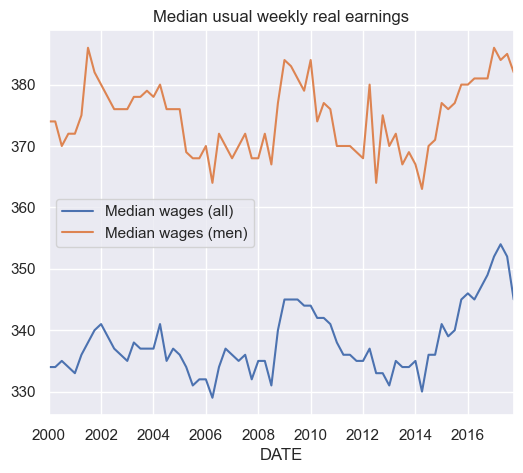

In [6]:
df_fred['2000':'2017'].plot()
plt.title('Median usual weekly real earnings');

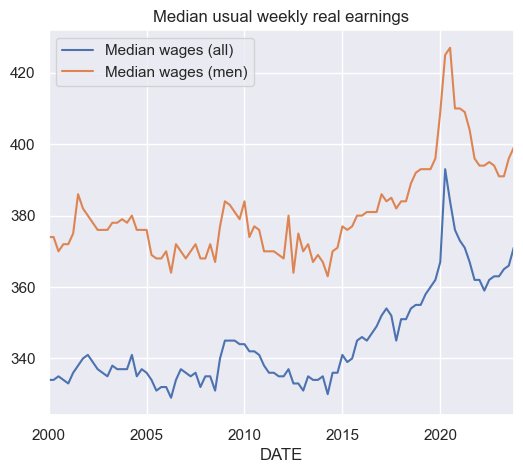

In [7]:
df_fred.plot()
plt.title('Median usual weekly real earnings');

## 2. Demographic data from US Current Population Survey

To study this puzzling fact, we will analyze how changing demographics might affect our aggregate measures of wages. One of our biggest concerns is that as employment rates fell, they fell more for low educated workers than high educated workers. That means the average wages we are measuring will actually be comparing different types of workers in 2010 relative to 2006. This could potentially explain why wages are rising. We will attempt to compensate for this by constructing a demographically adjusted time series for wages. 

### Game Plan

Here is a summary of what we will do. I will give you more specific instructions afterwards to walk you through this.

Use data from the 2000-2023 March CPS (downloaded from IPUMS CPS web site) to examine the time series (annual) trend in both nominal and real wages for 25-54 year old men not living in group quarters.  (You need to download the group quarters variable).  Wages will be defined as annual earnings (last year) divided by annual hours (last year).  Annual hours can be computed by multiplying weeks worked last year by usual hours worked (last year). You should do this for a sample of all workers with a positive wage last year. Typically, you can convert to real wages using any deflator you wish. Here, I will require using the CPI99 variable to convert to 1999 dollars. (Note: Many economists like to use the June CPI-U. June is in the middle of the year and, for that reason, avoids some issues with seasonality. The choice of year doesn't matter.)

#### Note about ASEC

Be sure to download **only** the ASEC samples. The ASEC supplement *is* the March CPS. The ASEC includes extra variables that are not included in the basic monthly CPS survey. From [Wikipedia, the ASEC is described as the following:](https://en.wikipedia.org/wiki/Current_Population_Survey#CPS_Annual_Social_and_Economic_Supplement_(ASEC)-_the_March_Supplement),

> Since 1948, the CPS has included supplemental questions (at first, in April; later, in March) on income received in the previous calendar year, which are used to estimate the data on income and work experience. These data are the source of the annual Census Bureau report on income, poverty, and health insurance coverage...

Downloading the March samples from the "Basic Monthly" samples doesn't give us what we need. See the included screenshot. The arrow points out the fact that these variables are missing in the March basic monthly samples but are available in the ASEC samples.

![asec_v_basic_monthly](https://user-images.githubusercontent.com/3770323/39500485-6fcfb1d0-4d7a-11e8-9fbf-45ff0272dd56.png)

### Step 2. Download and Read the CPS Data from IPUMS

When you download the data from IPUMS, *only download the data that you need*. This is important, because the data gets very big very fast when you start adding other variables. IPUMS will automatically add certain variables to your "cart". Go ahead and remove the ones that you don't need. This will make things much easier. The list of variables that you need are listed below. Make sure to stick to just those variables. You will fill in the code in the file called `load_cps.py` that will clean the raw IPUMS CPS data. This fill assumes that you have downloaded the data manually from the IPUMS CPS website as described above and saved it in the directory `../data/manual` relative to the source file. Relative to the project home directory, this is `./data/manual`. Recall that we are putting it in the `manual` directory instead of the `pulled` directory, because the data was not automatically pulled from the source.

Also, note that the to pass the unit tests used by the autograder, you must put the data in a file called `cps.csv` in the directory `./data/manual`. Also, please do NOT commit the data to your Git repository, because the data is very large. Here is a hint of what the file `load_cps.py` should look like:

```
import pandas as pd
import numpy as np

import config
DATA_DIR = config.DATA_DIR

def load_raw(data_dir=DATA_DIR, start_date='2000-01-01', end_date='2024-01-01'):
    
    ## Read and Prepare the Data

    # When you save the file, it must be named `cps.csv`
    # and saved in the directory `../data/manual`.
    # It is placed in the `manual` directory because it is not
    # automatically downloaded from the internet.
    path = data_dir / 'manual' / 'cps.csv'

    # YOUR CODE HERE

    return df

def load_clean(data_dir=DATA_DIR, start_date='2000-01-01', end_date='2024-01-01'):
    df = load_raw(data_dir, start_date, end_date)
    ## Fill in Missing Values or NIU
    
    # YOUR CODE HERE

    return df


if __name__ == "__main__":
    pass
```



The data should contain the following variables:

1. YEAR (Survey year)
2. GQ (Group Quarters status)
3. CPI99 (CPI-U adjustment factor to 1999 dollars)
4. ASECWT (Annual Social and Economic Supplement Weight)
5. AGE (Age)
6. SEX (Sex)
7. LABFORCE (Labor force status)
8. EDUC (Educational attainment recode)
9. WKSWORK1 (Weeks worked last year)
10. UHRSWORKLY (Usual hours worked per week (last yr))
11. INCWAGE (Wage and salary income)

When you're finished, run the following code to see how much memory your data set is using, the list of variables, and the data types each variable is saved as:


In [8]:
DATA_DIR = config.DATA_DIR
df = load_cps.load_raw(DATA_DIR)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4608387 entries, 0 to 4608386
Data columns (total 12 columns):
 #   Column      Dtype         
---  ------      -----         
 0   YEAR        datetime64[ns]
 1   GQ          category      
 2   CPI99       float64       
 3   CPSIDV      int64         
 4   ASECWT      float64       
 5   AGE         int64         
 6   SEX         category      
 7   LABFORCE    category      
 8   EDUC        category      
 9   WKSWORK1    int64         
 10  UHRSWORKLY  int64         
 11  INCWAGE     int64         
dtypes: category(4), datetime64[ns](1), float64(2), int64(5)
memory usage: 298.9 MB


As you can see, this results in
```
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4608387 entries, 0 to 4608386
Data columns (total 12 columns):
 #   Column      Dtype         
---  ------      -----         
 0   YEAR        datetime64[ns]
 1   GQ          category      
 2   CPI99       float64       
 3   CPSIDV      int64         
 4   ASECWT      float64       
 5   AGE         int64         
 6   SEX         category      
 7   LABFORCE    category      
 8   EDUC        category      
 9   WKSWORK1    int64         
 10  UHRSWORKLY  int64         
 11  INCWAGE     int64         
dtypes: category(4), datetime64[ns](1), float64(2), int64(5)
memory usage: 298.9 MB
```
If you use restrict your data set to exactly these variables and follow the instructions precisely, you should be able to replicate the exact numbers that I get. (For example, don't drop missing data until the instructions tell you to.)

In [9]:
df.describe()

,YEAR,CPI99,CPSIDV,ASECWT,AGE,WKSWORK1,UHRSWORKLY,INCWAGE
count,4608387,4608387.000,4608387.000,4608387.000,4608387.000,4608387.000,4608387.000,4608387.000
mean,2011-01-03 04:15:05.989538816,0.779,130758231204187.125,1663.893,35.299,23.545,511.494,23437302.472
min,2000-01-01 00:00:00,0.569,0.000,21.090,0.000,0.000,1.000,0.000
25%,2005-01-01 00:00:00,0.694,0.000,809.490,15.000,0.000,40.000,0.000
50%,2011-01-01 00:00:00,0.764,200403026765031.000,1493.780,35.000,6.000,70.000,28000.000
75%,2017-01-01 00:00:00,0.882,201301054209016.000,2178.210,52.000,52.000,999.000,145000.000
max,2023-01-01 00:00:00,1.000,202303068702011.000,44423.830,90.000,52.000,999.000,99999999.000
std,NaN,0.112,95860476618055.766,1212.633,22.322,24.775,480.187,42335696.104


When filling in the missing values, keep in mind the codings for each variable. Consult the associated codebook and IPUMS documentation for complete information. (I've included the codebook from my data extract in the file named: `cps_00007_codebook.pdf`) 

For your convenience, I've reproduced some information about some of our variables below. 

#### UHRSWORKLY

For UHRSWORKLY: Usual hours worked per week (last yr) https://cps.ipums.org/cps-action/variables/UHRSWORKLY#codes_section

    UHRSWORKLY is a 2-digit numeric value.

    99 = 99 hours or more 
    999 = NIU (Not in universe)
    
> WKSWORK1 reports the number of weeks, in single weeks, that the respondent worked for profit, pay, or as an unpaid family worker during the preceding calendar year. Respondents were prompted to count weeks in which they worked for even a few hours and to include paid vacation and sick leave as work. Information on weeks worked during the preceding year is available in the form of intervals for 1962 forward in the WKSWORK2 variable.

#### INCWAGE

For INCWAGE: Wage and salary income https://cps.ipums.org/cps-action/variables/INCWAGE#description_section

    Codes
    9999999 = N.I.U. (Not in Universe). 
    9999998 = Missing.
    
> INCWAGE indicates each respondent's total pre-tax wage and salary income--that is, money received as an employee--for the previous calendar year. Amounts are expressed as they were reported to the interviewer; users must adjust for inflation using Consumer Price Index adjustment factors.

> For ASEC samples 1988-onward, INCWAGE is derived from a Census recode variable. The topcoded components of INCWAGE are OINCWAGE and INCLONGJ. OINCWAGE is always a component of INCWAGE. When SRCEARN indicates that INCLONGJ is earned from wage and salary, INCLONGJ is an additional component of INCWAGE.
    
#### CPI99

For CPI99: CPI99 is a 4-digit variable with three implied decimal places. https://cps.ipums.org/cps-action/variables/CPI99#description_section

> CPI99 provides the CPI-U multiplier (available from the Bureau of Labor Statistics) to convert dollar figures to constant 1999 dollars. (This corresponds to the dollar amounts in the 2000 CPS, which inquired about income in 1999.) Multiplying dollar amounts by this variable (which is constant within years) will render them comparable across time and thus suitable for multivariate analysis.

> For more information on how to use CPI99, please see the IPUMS inflation adjustment page.

#### LABFORCE 

https://cps.ipums.org/cps-action/variables/LABFORCE#codes_section

    Codes:
    0   NIU
    1   No, not in the labor force
    2   Yes, in the labor force

> LABFORCE is a dichotomous variable indicating whether the respondent participated in the labor force during the preceding week. See EMPSTAT for a more detailed employment status variable. Those coded as "yes" in LABFORCE were either: were at work; held a job but were temporarily absent from work due to factors like vacation or illness; were seeking work; or were temporarily laid off from a job during the reference period.

> Because the CPS is designed to measure unemployment in the civilian population, the original dichotomous employment status variable in the survey classifies members of the armed forces as NIU (Not in universe).

### Step 3. Recode the missing data

Each variable in the CPS data that we downloaded has specific codes used to represent missing data. There is also a difference between data that is missing and data that is considered "NIU", meaning "Not in Universe." Consult the documentation for the meaning of each of the codes for each of the variables. Convert all missing values and NIU values to `np.nan`.

For example, you should include the following code for INCWAGE:

```python
# INCWAGE: Missing values
# 9999999 = N.I.U. (Not in Universe). 
# 9999998 = Missing.
df.loc[df['INCWAGE'] == 9999999, 'INCWAGE'] = np.nan
df.loc[df['INCWAGE'] == 9999998, 'INCWAGE'] = np.nan
```

*Be sure to look at the encodings on IPUMS to make sure you're properly coding all variables in your dataset---not just the ones that I listed above (not necessarily comprehensive).*

In [10]:
df = load_cps.load_clean(DATA_DIR)
df.describe()

,YEAR,CPI99,CPSIDV,ASECWT,AGE,WKSWORK1,UHRSWORKLY,INCWAGE
count,4608387,4608387.000,4608387.000,4608387.000,4608387.000,4608387.000,2339421.000,4608387.000
mean,2011-01-03 04:15:05.989538816,0.779,130758231204187.125,1663.893,35.299,23.545,38.670,23437302.472
min,2000-01-01 00:00:00,0.569,0.000,21.090,0.000,0.000,1.000,0.000
25%,2005-01-01 00:00:00,0.694,0.000,809.490,15.000,0.000,36.000,0.000
50%,2011-01-01 00:00:00,0.764,200403026765031.000,1493.780,35.000,6.000,40.000,28000.000
75%,2017-01-01 00:00:00,0.882,201301054209016.000,2178.210,52.000,52.000,40.000,145000.000
max,2023-01-01 00:00:00,1.000,202303068702011.000,44423.830,90.000,52.000,99.000,99999999.000
std,NaN,0.112,95860476618055.766,1212.633,22.322,24.775,12.143,42335696.104


### Step 4. Select the desired subsample of the data

As we mentioned, we want to narrow the demographic group under consideration. Drop all observations from `df` that don't match the following conditions.

> Use data from the 2000-2023 March CPS for 25-54 year old men not living in group quarters. Only consider individuals with a strictly positive income from wages.

For example, your code might start like this:

```python
# GQ = 0 for vacant units, 1 for Households, 2 for group quarters
df = df[df['GQ'] == 1]
```

In [11]:
df = wage_growth_analytics.s04_subsample(df)
df.describe()

,YEAR,CPI99,CPSIDV,ASECWT,AGE,WKSWORK1,UHRSWORKLY,INCWAGE
count,769289,769289.000,769289.000,769289.000,769289.000,769289.000,769289.000,769289.000
mean,2010-09-12 14:19:39.280088576,0.784,129017301880106.188,1680.482,39.524,49.189,43.372,58904.663
min,2000-01-01 00:00:00,0.569,0.000,25.330,25.000,1.000,1.000,1.000
25%,2005-01-01 00:00:00,0.703,0.000,816.090,33.000,52.000,40.000,26000.000
50%,2010-01-01 00:00:00,0.774,200312067062011.000,1503.350,40.000,52.000,40.000,44000.000
75%,2016-01-01 00:00:00,0.882,201203011452011.000,2177.640,47.000,52.000,48.000,70000.000
max,2023-01-01 00:00:00,1.000,202303068387021.000,44423.830,54.000,52.000,99.000,2099999.000
std,NaN,0.113,96368008905273.844,1246.006,8.324,8.458,9.639,67907.862


### Step 5. Construct new  variables

Now, construct new variables called `real_incwage`, `annual_hours`, `real_wage`, and `in_labor_force`.

 - `real_incwage` is the CPI99 deflator times annual earnings (last year)
 - `annual_hours` is the weeks worked last year times the usual hours worked per week (last year).
 - `real_wage` is the annual earnings (last year) divided by annual hours (last year). Be sure to set `real_wage` equal to zero whenever `annual_hours` is equal to zero. (I use the following code:
 ```python
# To prevent infinite wages
df.loc[df['annual_hours'] <= 0, 'real_wage'] = 0
 ```
 - `in_labor_force` is a boolean variable that is True if the individual was coded as "Yes, in the labor force." Use the `LABFORCE` variable for this.



In [12]:
df = wage_growth_analytics.s05_new_vars(df)
df.describe()

,YEAR,CPI99,CPSIDV,ASECWT,AGE,WKSWORK1,UHRSWORKLY,INCWAGE,real_incwage,annual_hours,real_wage
count,769289,769289.000,769289.000,769289.000,769289.000,769289.000,769289.000,769289.000,769289.000,769289.000,769289.000
mean,2010-09-12 14:19:39.280088576,0.784,129017301880106.188,1680.482,39.524,49.189,43.372,58904.663,45146.824,2146.530,21.946
min,2000-01-01 00:00:00,0.569,0.000,25.330,25.000,1.000,1.000,1.000,0.726,1.000,0.000
25%,2005-01-01 00:00:00,0.703,0.000,816.090,33.000,52.000,40.000,26000.000,20904.000,2080.000,10.385
50%,2010-01-01 00:00:00,0.774,200312067062011.000,1503.350,40.000,52.000,40.000,44000.000,34086.000,2080.000,15.772
75%,2016-01-01 00:00:00,0.882,201203011452011.000,2177.640,47.000,52.000,48.000,70000.000,53625.000,2340.000,24.188
max,2023-01-01 00:00:00,1.000,202303068387021.000,44423.830,54.000,52.000,99.000,2099999.000,1352399.356,5148.000,312342.282
std,NaN,0.113,96368008905273.844,1246.006,8.324,8.458,9.639,67907.862,50168.412,607.767,368.105


### Step 6. Drop data that we no longer need.

 - Run the code below to drop data that we don't need.
 
```python
# Drop the variables that don't need anymore.
# Your data might not have some of these variables. 
labels = ['GQ', 'SEX', 'LABFORCE', 'CPI99', 'INCTOT', 'WKSWORK1', ]
for label in labels:
    try:
        df.drop(labels=label, inplace=True, axis=1)
    except:
        pass   
```
 - Also, after you do this, you should drop all rows that contain a missing value.

In [13]:
df = wage_growth_analytics.s06_drop(df)

### Step 7. Generate summary statistics

Use `describe` to generate summary statistics for at least the following variables:
`AGE`, `INCWAGE`, `real_incwage`, `annual_hours`, `real_wage`. (For now, disregard the fact that we need to use the survey weights to compute these figures.) What do you notice about the top end of the distribution of `real_wage`?

At this point, your answer should look like this: 
![](./assets/q7_df_describe.png)

In [14]:
# There seem to be some very large wages at the top end of `real_wage`
df.describe()

,YEAR,CPSIDV,ASECWT,AGE,UHRSWORKLY,INCWAGE,real_incwage,annual_hours,real_wage
count,769289,769289.000,769289.000,769289.000,769289.000,769289.000,769289.000,769289.000,769289.000
mean,2010-09-12 14:19:39.280088576,129017301880106.188,1680.482,39.524,43.372,58904.663,45146.824,2146.530,21.946
min,2000-01-01 00:00:00,0.000,25.330,25.000,1.000,1.000,0.726,1.000,0.000
25%,2005-01-01 00:00:00,0.000,816.090,33.000,40.000,26000.000,20904.000,2080.000,10.385
50%,2010-01-01 00:00:00,200312067062011.000,1503.350,40.000,40.000,44000.000,34086.000,2080.000,15.772
75%,2016-01-01 00:00:00,201203011452011.000,2177.640,47.000,48.000,70000.000,53625.000,2340.000,24.188
max,2023-01-01 00:00:00,202303068387021.000,44423.830,54.000,99.000,2099999.000,1352399.356,5148.000,312342.282
std,NaN,96368008905273.844,1246.006,8.324,9.639,67907.862,50168.412,607.767,368.105


In [15]:
df.query('real_wage > 300000')

,YEAR,CPSIDV,ASECWT,AGE,EDUC,UHRSWORKLY,INCWAGE,real_incwage,annual_hours,real_wage,in_labor_force
1944649,2009-01-01,200802018016011,3381.190,48,73,1.000,403543.000,312342.282,1.000,312342.282,True


### Step 8. Plot a histogram of the average weekly hours and the average annual hours worked.

That is, plot a histogram of `UHRSWORKLY` and for a histogram of `annual_hours`.

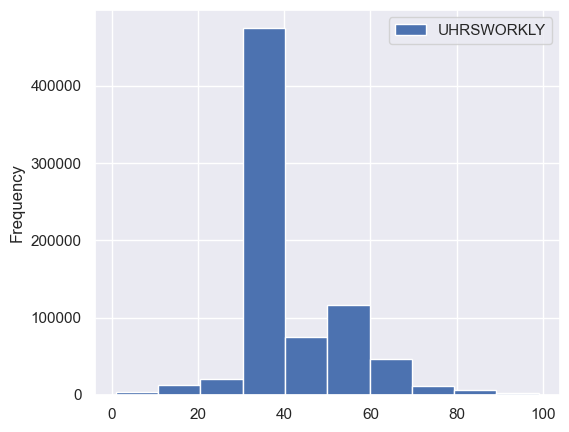

In [16]:
df[['UHRSWORKLY']].plot.hist();

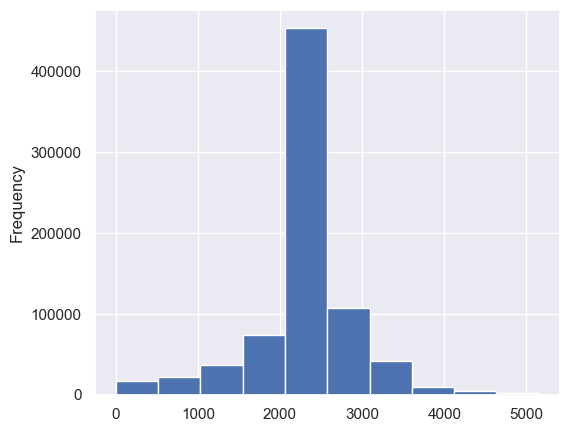

In [17]:
df['annual_hours'].plot.hist();

### Step 9. Plot a histogram of real wages.

 - Plot a histogram of `real_wage` using the default number of bins in pandas.
 - Plot a histogram of `real_wage` for only those with `real_wage` less than 200. Use the default number of bins.
 - Plot a histogram of `real_wage` for only those with `real_wage` less than 200. Use 50 bins.

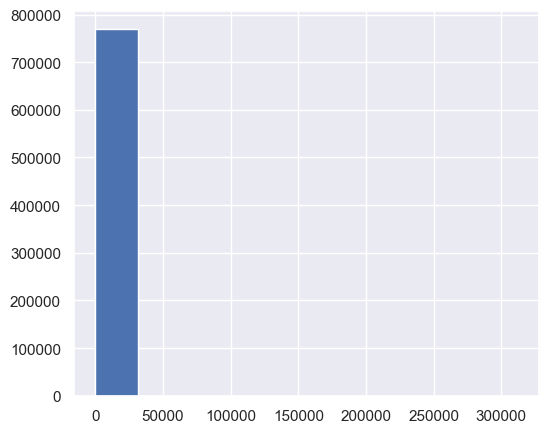

In [18]:
df['real_wage'].hist();

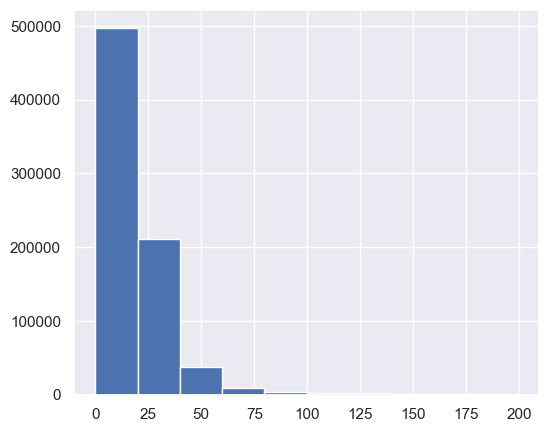

In [19]:
df.loc[df['real_wage'] < 200,'real_wage'].hist();

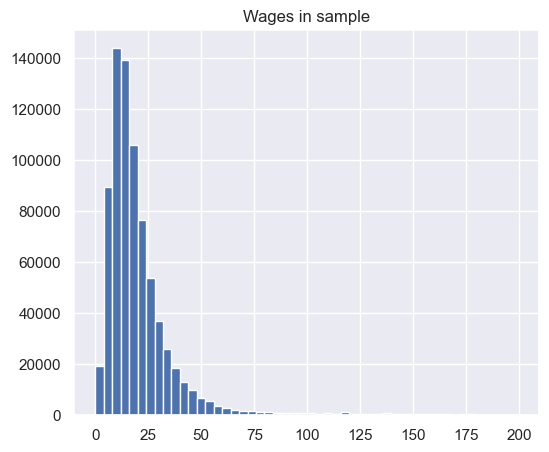

In [20]:
df.loc[df['real_wage'] < 200,'real_wage'].hist(bins=50)
plt.title('Wages in sample');

### Step 10. Drop all rows that have wages above the 99th percentile and below the 1st percentile.

For example, use the code `q01 = df.real_wage.quantile(q=0.01)` to compute the 1st percentile. Then use `df = df[YOUR_MASK_HERE]` or use `df = df.query(YOUR_CODE_HERE)`.

In [21]:
df = wage_growth_analytics.s10_drop_by_percentiles(df)

In [22]:
df.describe()

,YEAR,CPSIDV,ASECWT,AGE,UHRSWORKLY,INCWAGE,real_incwage,annual_hours,real_wage
count,753893,753893.000,753893.000,753893.000,753893.000,753893.000,753893.000,753893.000,753893.000
mean,2010-09-15 20:14:58.255853568,129070305877238.188,1680.891,39.499,43.397,55359.313,42445.377,2150.577,19.419
min,2000-01-01 00:00:00,0.000,25.330,25.000,1.000,8.000,6.432,1.000,2.375
25%,2005-01-01 00:00:00,0.000,816.240,33.000,40.000,27000.000,21168.000,2080.000,10.471
50%,2010-01-01 00:00:00,200312068805051.000,1503.170,40.000,40.000,44000.000,34120.000,2080.000,15.772
75%,2016-01-01 00:00:00,201203018008021.000,2178.200,46.000,47.000,70000.000,53040.000,2340.000,23.930
max,2023-01-01 00:00:00,202303068387021.000,44423.830,54.000,99.000,850000.000,554200.000,5148.000,116.576
std,NaN,96352940439692.078,1246.555,8.321,9.507,46939.778,35094.710,598.662,13.974


<Axes: >

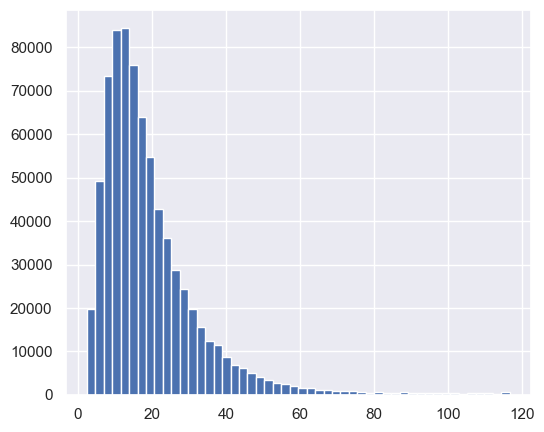

In [23]:
df['real_wage'].hist(bins=50)

## 3. Recreate a Wage Series Like The One From FRED

### Step 11. Create time series for wages and employment

These first series that we create will not be demographically adjusted. Create these series with the following variable names: `median_wages`, `ave_wages`, and `employment`. Each of these should be computed using the survey weights. Notice that `np.average` has a keyword argument for weights. To construct a weighted median, we will use the `weightedstats` package.

Here is the code to compute the weighted median. Fill in the rest of the code for the other variables.

```python
col = 'real_wage'
weights='ASECWT'

median_wages = (
    df
    .dropna(subset=[col], how='any')
    .groupby('YEAR')
    .apply(lambda row: weightedstats.weighted_median(row[col], weights=row[weights]))
    # Shift time back since the series represents wages from the previous year
    .shift(-1) 
)
```

NOTE: Wage data needs to be shifted backwards, but employment data does not need to be.

In [24]:
median_wages = wage_growth_analytics.s11_median_wages(df)
ave_wages = wage_growth_analytics.s11_ave_wages(df)
employment = wage_growth_analytics.s11_employment(df)

### Step 12. Concatenate these time series variables together.

Use `pd.concat` to create a new DataFrame called `tdf` that contains `median_wages`, `ave_wages`, and `employment`. Make sure that the column names are preserved in `tdf`.

Running `tdf.head()` should produce the following result at this point.

![`tdf.head()`](./assets/time_series.png)

In [25]:
tdf = wage_growth_analytics.s12_time_series(df)

In [26]:
tdf.head()

,ave_wages,median_wages,employment
YEAR,,,
2000-01-01,18.930,15.807,0.966
2001-01-01,19.542,15.834,0.965
2002-01-01,19.178,15.582,0.966
2003-01-01,18.915,15.663,0.964
2004-01-01,18.743,15.508,0.964


### Step 13. Plot the series

Plot `ave_wages` and `median_wages` on the same plot. Make another plot for `employment`.

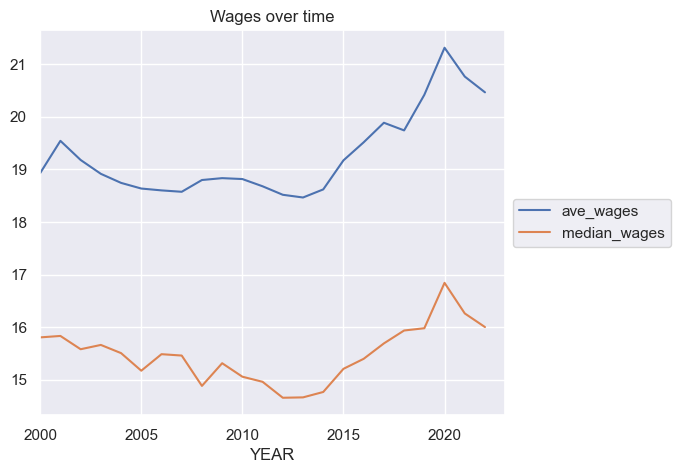

In [27]:
tdf[['ave_wages', 'median_wages']].plot(title='Wages over time')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));

<Axes: title={'center': 'Employment'}, xlabel='YEAR'>

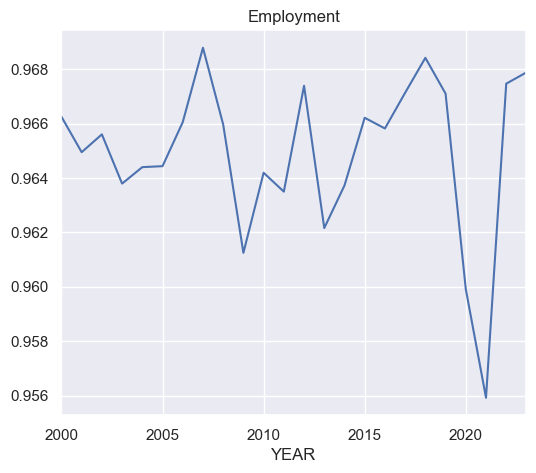

In [28]:
employment.plot(title='Employment')

### Step 14. Compute the autocorrelation of each variables in `tdf`

HINT: You can compute the autocorrelation of a single series using, e.g., `tdf.ave_wages.autocorr()`. You can do this for each series in `tdf` in one go by using `tdf.apply(lambda x: YOUR_CODE_HERE)`.

In [29]:
#autocorrelation
tdf.apply(lambda x: x.autocorr())

ave_wages      0.895
median_wages   0.795
employment     0.189
dtype: float64

### Step 15. Compute the contemporeneous correlation between the variables in `tdf`.

This amounts to simply calculating the correlation matrix.

In [30]:
tdf.corr()

,ave_wages,median_wages,employment
ave_wages,1.000,0.856,-0.280
median_wages,0.856,1.000,-0.211
employment,-0.280,-0.211,1.000


### Step 16. Plot median wages and employment on the same graph

Use the following starter code to plot these two series on the same graph, with separate y-axes (a left y-axis and a right y-axis).

<!--
```python
ax = YOUR_CODE_HERE.plot(legend=False, color='red')
ax.grid(False)
ax.set_ylabel('Median Wages')
ax2 = ax.twinx()
ax2.grid(False)
ax2.set_ylabel('Employment')
tdf.employment.plot(ax=ax2)
ax.figure.legend()
```
-->

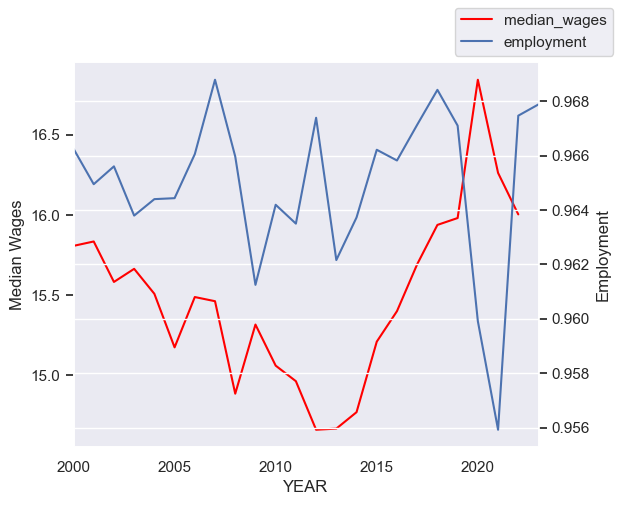

In [31]:
ax = tdf[['median_wages']].plot(legend=False, color='red', label='Wght. Median Wages')
ax.grid(False)
ax.set_ylabel('Median Wages')
ax2 = ax.twinx()
ax2.grid(False)
ax2.set_ylabel('Employment')
tdf.employment.plot(ax=ax2)
ax.figure.legend()

### Step 17. Plot median wages growth and employment on the same graph

First, create new variables in `tdf` called `ave_wage_growth` and `median_wage_growth`. Apply the method `pct_change()` to the appropriate columns to create the new variable. This will compute the percent changes in each variable over time. Use the same code as from before to make the plot, but substitute in your new variable. Be sure to update the label on the axes. 

Note: When computing various statistics, for example correlations, we want to beware of variables that are steadily growing or shrinking over time. Variables like this are said to be *non-stationary.* Usage of such variables without care can often lead to [spurious correlations.](https://en.wikipedia.org/wiki/Spurious_relationship#Examples) In time series econometrics, there are various ways of transforming these variables into stationary variables. One method, which we'll use here, is to compute percentage differences. Since we believe wages tend to increase over time, we want to difference (in our case, compute percentage differences) the wage variable. Our employment variable, however, is a ratio between zero and one that is not steadily growing or shrinking. So it's ok.

In [32]:
tdf['ave_wage_growth'] = tdf['ave_wages'].pct_change(fill_method=None)
tdf['median_wage_growth'] = tdf['median_wages'].pct_change(fill_method=None)

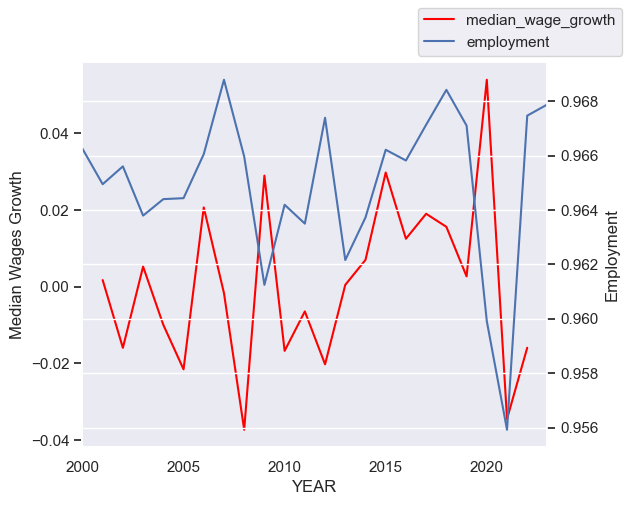

In [33]:
ax = tdf['median_wage_growth'].plot(legend=False, color='red')
ax.grid(False)
ax.set_ylabel('Median Wages Growth')
ax2 = ax.twinx()
ax2.grid(False)
ax2.set_ylabel('Employment')
tdf['employment'].plot(ax=ax2)
ax.figure.legend();

In [34]:
## Extra:
# Note that it appears that employment and wage growth
# is slightly out of phase. This could be because the two
# are negatively correlated. Or maybe it's because we shouldn't
# have shifted wages back---even though it seemed like the appropriate
# thing to do given the definition of wages. We should probably
# leave it as it is, though.
print(tdf[['median_wage_growth']].corrwith(tdf.employment))
print(tdf[['median_wage_growth']].shift(1).corrwith(tdf.employment))

median_wage_growth   -0.009
dtype: float64
median_wage_growth   -0.151
dtype: float64


### Step 18. Plot median wages growth and employment *growth* on the same graph

Create a new variable in `tdf` called `employment_growth`. Again use `.pct_change()` to create it.
Use the same code as from before. However, this time let's explore the relationship of wages with employment *growth* rather than the employment *level*. Be sure to update the labels of the axes so that we know what we're looking at.

In [35]:
tdf['employment_growth'] = tdf['employment'].pct_change(fill_method=None)

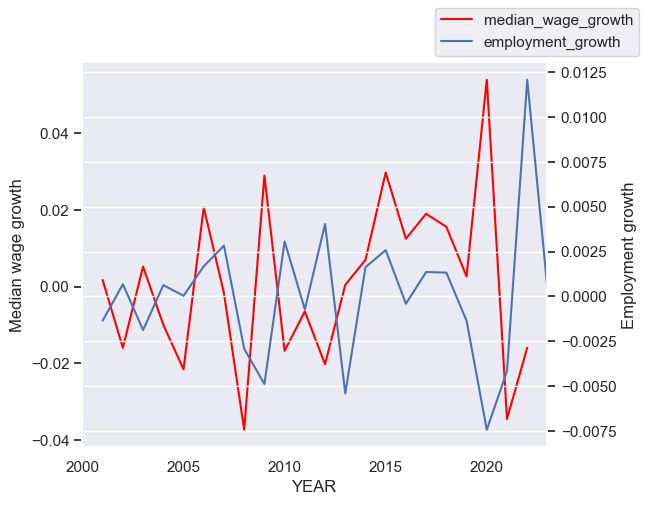

In [36]:
ax = tdf['median_wage_growth'].plot(legend=False, color='red')
ax.grid(False)
ax.set_ylabel('Median wage growth')
ax2 = ax.twinx()
ax2.grid(False)
ax2.set_ylabel('Employment growth')
tdf['employment_growth'].plot(ax=ax2)
ax.figure.legend()

### Step 19. Use the code below as well as the graphs from before to describe what we're seeing in the data.

Use `.corr()` to compute the correlations between the various wage growth series and the measures of employment in `tdf`. Give a summary of what you're seeing in the data. How does it match up with your intution and with your understanding of supply and demand in labor markets?

In [37]:
tdf.corr()

,ave_wages,median_wages,employment,ave_wage_growth,median_wage_growth,employment_growth
ave_wages,1.000,0.856,-0.280,0.339,0.247,-0.113
median_wages,0.856,1.000,-0.211,0.233,0.345,-0.147
employment,-0.280,-0.211,1.000,0.113,-0.009,0.645
ave_wage_growth,0.339,0.233,0.113,1.000,0.601,-0.287
median_wage_growth,0.247,0.345,-0.009,0.601,1.000,-0.262
employment_growth,-0.113,-0.147,0.645,-0.287,-0.262,1.000


Solution:

This is an open-ended question. As long as you provide a reasonable response, that should be fine. I see that
wages growth is slightly positively correlated with the level of employment. It's small enough, though, that I might say that they are uncorrelated. Median wage growth appears to be negatively correlated with employment. My intuition, coming from my understanding of supply and demand, is that wage growth should be higher when employment is higher. They should be positively correlated. This doesn't appear to be the case. We see a similar fact when we compare wage growth to employment growth. The same intuition seems like it could apply when comparing wage growth and employment growth.

## 4. Create Demographically Adjusted Series

Here we will demographically adjust the data to adjust for composition changes over time (based on observables).  As employment rates fell, they fell more for low educated workers than high educated workers.  That means the average wages you measured previously will actually be comparing different types of workers in 2010 relative to 2006. To demographically adjust the data, create age-skill groups in each year. Use 5 year age ranges (25-29, 30-34, etc.) and 5 education groupings (less than high school, high school only, some college, bachelor’s degree, more than a bachelor’s degree). Compute wages within these cells for each year (again weighting the data using survey weights). However, when computing time series trends, we will fix the population weights for each cell at year 2000 levels (i.e., the share of the population that lives in each group). So, for each year, you will compute a measure of wages by multiplying the means within each cell during that year by the 2000 shares of population in each cell (and then sum across cells within the year). By doing this, you will be able to compute a demographically adjusted wage series during the 2000 – 2022 period (we have data up to 2023, but the wage variables refer to the wages earned in the previous year). We will discuss how these demographically adjusted wage series compare to your series from before.

### Step 20. Create new variables in `df` for age and education bins.

To demographically adjust the data, create age-skill groups in each year. Use 5 year age ranges (25-29, 30-34, etc.) and 5 education groupings (less than high school, high school only, some college, bachelor’s degree, more than a bachelor’s degree).

I have provided starter code here:

```python
# Add bins to `df` for the AGE and EDUC variables as described in
# Question 1.B of the HW.
bins = [25, ... YOUR_CODE_HERE ... , 55]
df['age_binned'] = pd.cut(df['AGE'], bins=bins, include_lowest=True, right=False)

educ_bins = [0, 72, 73, YOUR_CODE_HERE , 900]
educ_bin_labels = ['Some_High_School', 'High_School_Diploma', 'Some_College',
                   'Bachelors_Degree', 'Beyond_Bachelors']
df['educ_binned'] = pd.cut(df['EDUC'], bins=educ_bins, labels=YOUR_CODE_HERE, include_lowest=True)
```

In [38]:
df = wage_growth_analytics.s20_bin_vars(df)

### Step 21. Compute the average wages within each education and age group as defined above.

Within in "cell", compute the average wage. You will need to use the survey weights to compute each mean within each cell. The result will be average real wages (deflated with CPI 99) computed over the cross-section and over time.

For a nicer display at the end, run a code cell with the code `pd.DataFrame(group_means)`.

In [39]:
group_means = wage_growth_analytics.s21_within_group_averages(df)

In [40]:
group_means

age_binned  educ_binned        
[25, 30)    Some_High_School       9.827
            High_School_Diploma   12.161
            Some_College          13.493
            Bachelors_Degree      18.297
            Beyond_Bachelors      21.492
[30, 35)    Some_High_School      10.574
            High_School_Diploma   13.539
            Some_College          15.705
            Bachelors_Degree      22.004
            Beyond_Bachelors      26.648
[35, 40)    Some_High_School      11.109
            High_School_Diploma   14.907
            Some_College          17.823
            Bachelors_Degree      25.529
            Beyond_Bachelors      31.476
[40, 45)    Some_High_School      11.696
            High_School_Diploma   15.616
            Some_College          18.792
            Bachelors_Degree      26.957
            Beyond_Bachelors      33.666
[45, 50)    Some_High_School      12.049
            High_School_Diploma   16.020
            Some_College          19.561
            Bachelors_Deg

In [41]:
pd.DataFrame(group_means)

average_wage
age_binned educ_binned                      
[25, 30)   Some_High_School            9.827
           High_School_Diploma        12.161
           Some_College               13.493
           Bachelors_Degree           18.297
           Beyond_Bachelors           21.492
[30, 35)   Some_High_School           10.574
           High_School_Diploma        13.539
           Some_College               15.705
           Bachelors_Degree           22.004
           Beyond_Bachelors           26.648
[35, 40)   Some_High_School           11.109
           High_School_Diploma        14.907
           Some_College               17.823
           Bachelors_Degree           25.529
           Beyond_Bachelors           31.476
[40, 45)   Some_High_School           11.696
           High_School_Diploma        15.616
           Some_College               18.792
           Bachelors_Degree           26.957
           Beyond_Bachelors           33.666
[45, 50)   Some_High_School           12.049
           High_School_Diploma        16.020
           Some_College               19.561
           Bachelors_Degree           27.783
           Beyond_Bachelors           34.611
[50, 55)   Some_High_School           12.237
           High_School_Diploma        16.587
           Some_College               19.932
           Bachelors_Degree           27.758
           Beyond_Bachelors           34.839

### Step 22. Display average wages within each education and age group as a table.

Use the `group_means` variable from before. Use `unstack`. Be sure to rearrange to columns so that the education levels appear in the correct order, from lowest educated to highest.

The end results should look like this:

![Means within each group](./assets/table_groups.png)

In [42]:
a = group_means.unstack()
cols = ['Some_High_School', 'High_School_Diploma', 'Some_College', 'Bachelors_Degree', 'Beyond_Bachelors']
# I am doing this to reorder the columns in the way that I want.
a = a[cols]
a

educ_binned,Some_High_School,High_School_Diploma,Some_College,Bachelors_Degree,Beyond_Bachelors
age_binned,,,,,
"[25, 30)",9.827,12.161,13.493,18.297,21.492
"[30, 35)",10.574,13.539,15.705,22.004,26.648
"[35, 40)",11.109,14.907,17.823,25.529,31.476
"[40, 45)",11.696,15.616,18.792,26.957,33.666
"[45, 50)",12.049,16.020,19.561,27.783,34.611
"[50, 55)",12.237,16.587,19.932,27.758,34.839


### Step 23. Plot the previous table as a heatmat.

Use seaborn's `heatmap` function. Just input the table from before into `sns.heatmap`. Be sure to use `plt.title` to give the plot an appropriate title.

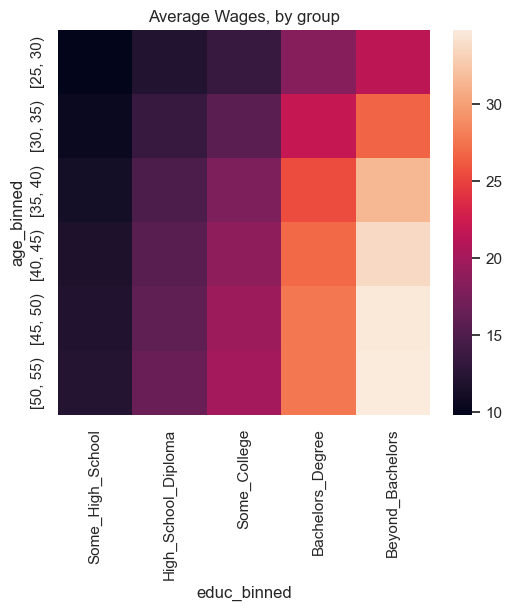

In [43]:
sns.heatmap(a)
plt.title('Average Wages, by group');

### Step 24. Create the demographically adjusted series

Now we will compute a demographically adjusted average wage series. To do this, average real wages within demographic groups. These groups will be grouped by year, age bin, and education level. These `inner_means` will be weighted using survey weights. Recall that the survey weights are given in the CPS data to tell us how to weight the data so that it is a statisitcally representative sample. We will then sum these survey weights within each group, or "cell". We will then use these summed survey weights from the age and education groups, and freeze them at year 2000. We will use these frozen weights to compute an adjusted time series for average wages for the rest of the years. Specifically, we will compute an average of the average group wages. (Note that an average of an average has a mathematically reasonable meaning.) 

Use the following started code to complete this:
<!--
```python
shift = -1
inner_means = (df
               .groupby(by=['YEAR', 'age_binned', YOUR_CODE_HERE], observed=False)
               .apply(lambda x: np.average(YOUR_CODE_HERE, weights=x['ASECWT']))
              )


# Create Bin Weight Sums
weights_2000 = (df[df.YEAR == YOUR_CODE_HERE]
                .dropna()
                .groupby(by=[YOUR_CODE_HERE, 'educ_binned'], observed=False)
                ['ASECWT']
                .sum()
               )

adj_series = (inner_means
              .groupby(level='YEAR')
              .apply(lambda x: np.average(x, weights=weights_2000)))
# Lag, since the we use "last years weeks worked", etc.
adj_series = adj_series.shift(shift)
tdf['adj_ave_wages'] = adj_series
```
-->
After doing this, construct the variable `adj_ave_wage_growth` using `.pct_change` as before.

In [44]:
tdf = wage_growth_analytics.s24_demographically_adj_series(df, tdf)

In [45]:
tdf.tail()

,ave_wages,median_wages,employment,ave_wage_growth,median_wage_growth,employment_growth,adj_ave_wages,adj_ave_wage_growth
YEAR,,,,,,,,
2019-01-01,20.416,15.980,0.967,0.034,0.003,-0.001,19.369,0.022
2020-01-01,21.311,16.843,0.960,0.044,0.054,-0.007,20.127,0.039
2021-01-01,20.763,16.262,0.956,-0.026,-0.034,-0.004,19.554,-0.028
2022-01-01,20.464,16.003,0.967,-0.014,-0.016,0.012,19.121,-0.022
2023-01-01,NaN,NaN,0.968,NaN,NaN,0.000,NaN,NaN


### Step 25. Check understanding of usage of `groupby` above.

Explain the following. Why did I use `groupby(by=[])` in one place and `groupby(level=...)` in another place? Explain the difference between the `by` keyword and the `level` keyword in the `groupby` function. (HINT: Check the documentation and run the code line by line if it's unclear.)

In [46]:
# The difference is that one groups by columns and the other groups by a level in a multi-index.

### Step 26. Plot the unadjusted and the demographically adjusted series for average wages on the same plot.

Also, explain what you see.

ANSWER:

In the plot immediately below, we see that the demographically adjusted wage series (`adj_ave_age`) coincides with the unadjusted series in the year 1999 (data from 2000). They diverge as time goes on. This is as expected, and serves as a check that we have performed our calculations correctly. The adjusted wage series is lower than the unadjusted. This suggests that the composition of the labor force was tilting towards higher earning demographics.

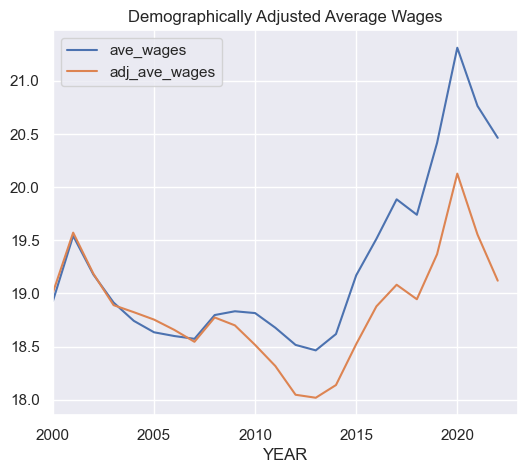

In [47]:
# In the plot immediately below, we see that the demographically 
# adjusted wage series (`adj_ave_age`) coincides with the unadjusted 
# series in the year 1999 (data from 2000). 
# They diverge as time goes on. This is as expected, and serves as a 
# check that we have performed our calculations correctly. 
# The adjusted wage series is lower than the unadjusted. 
# This suggests that the composition of the labor force was tilting 
# towards higher earning demographics.
tdf[['ave_wages', 'adj_ave_wages']].plot()
plt.title("Demographically Adjusted Average Wages");

### Step 27. Repeat the calculations from Q19, except include the new adjusted series as well. 

What do you see? Is it still puzzling? (NOTE: This is mostly an open-ended question.)

ANSWER:

Now, if we repeat our calculations with regards to the time series correlation between wage growth and employment, we see that demographically adjusting wage growth lowers the correlation. The correlation of wage growth and employment growth become more negative. This is also a little puzzling.

In [48]:
tdf.corr()

,ave_wages,median_wages,employment,ave_wage_growth,median_wage_growth,employment_growth,adj_ave_wages,adj_ave_wage_growth
ave_wages,1.000,0.856,-0.280,0.339,0.247,-0.113,0.842,0.276
median_wages,0.856,1.000,-0.211,0.233,0.345,-0.147,0.926,0.202
employment,-0.280,-0.211,1.000,0.113,-0.009,0.645,-0.266,0.078
ave_wage_growth,0.339,0.233,0.113,1.000,0.601,-0.287,0.350,0.974
median_wage_growth,0.247,0.345,-0.009,0.601,1.000,-0.262,0.214,0.581
employment_growth,-0.113,-0.147,0.645,-0.287,-0.262,1.000,-0.271,-0.370
adj_ave_wages,0.842,0.926,-0.266,0.350,0.214,-0.271,1.000,0.340
adj_ave_wage_growth,0.276,0.202,0.078,0.974,0.581,-0.370,0.340,1.000


## 5. Conclusion

Note that there is more that we could do with this. For one, we could try to account for changes in employment. For example, the procedure would work like this:

> We could impute wages for those not working.  So your sample will now expand to all workers – even those without a measured wage.   We can do the imputation in a crude way. Using this new sample, define demographic groups by age-skill for each year. For each person without out a wage in a given year – match them to their demographic cell in that year.  For your imputation, assign those with a missing wage in that year to the 33rd percentile of the wages within that cell (for that year).   Note – those with the highest wages will be at the 99th percentile.  This assumes that those with a missing wage (of a given age-skill type) are disproportionately drawn from the bottom part of their age-skill wage distribution.   Still adjust the wages for changing demographic composition by fixing the weights for each demographic cell at their 2000 level (using the full sample including the zeros).  

We could then ask ,how do the time series patterns in these demographically adjusted wages (including the zeros) compare to the wage series created previously?  How would things change if you used the 50th percentile to conduct the imputation?

In addition, we could also repeat this exercise using data from the 2000 Census and the 2001-2014 American Community Survey (downloaded from the IPUMS USA website---a different data set from the IPUMS CPS data set that we used here).

All of these things could help us to better understand this puzzling fact that we see in the data.

<!--
## Appendix: Other Methods of Creating Adjusted Series

For fun, below is an attempt at creating something similar to a demographically adjusted median wage series

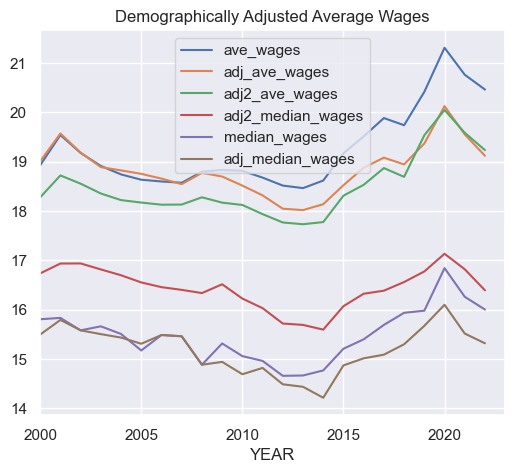